In [1]:
import os
os.chdir('/home/delsignores/defects_DLMBL')

In [2]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader
from defects_dlmbl.datamodules import  ISBIDataset, CREMIDataset
from defects_dlmbl.datamodules import CREMIDataModule
import matplotlib.pyplot as plt
from defects_dlmbl import segment_affinities as seg
import numpy as np

In [3]:
dm = CREMIDataModule('/home/delsignores/defects_DLMBL/data/training_data.zarr')

In [4]:
dataset = CREMIDataset('/home/delsignores/defects_DLMBL/data/training_data.zarr')

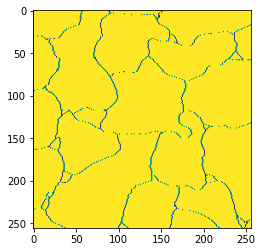

In [5]:
plt.imshow(dataset[0][1][1])

In [6]:
aff=dataset.affinities(dataset[0][1][1])
aff[1]

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]])

Text(0.5, 1.0, 'Aff')

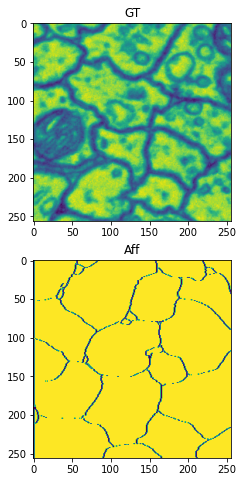

In [7]:
fig, axes = plt.subplots(2, figsize=(15, 8))
axes[0].imshow(dataset[0][0].squeeze())
axes[0].set_title('GT')
axes[1].imshow(aff[1])
axes[1].set_title('Aff')  

In [8]:
affs = np.stack([
np.zeros_like(aff[0]),
aff[1],
aff[0]])

# waterz agglomerate requires 4d affs (c, d, h, w) - add fake z dim
affs = np.expand_dims(affs, axis=1)
affs

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         ...,
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True],
         [False, False,  True, ...,  True,  True,  True]]],


       [[[False, False, False, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True

In [9]:
testseg = seg.get_segmentation(affs.astype(np.float), .3)
testseg = testseg.astype(np.uint64)
testseg.max()

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  1.          1.
   1.        ]
 [ 0.          0.          1.         ...  2.          2.
   2.        ]
 ...
 [ 0.          0.          1.         ... 29.52964612 30.01666204
  30.52867504]
 [ 0.          0.          1.         ... 30.41381265 30.88689042
  31.38470965]
 [ 0.          0.          1.         ... 31.30495168 31.76476035
  32.24903099]]
Found 40 fragments
Re-using already compiled waterz version
Preparing segmentation volume...


2

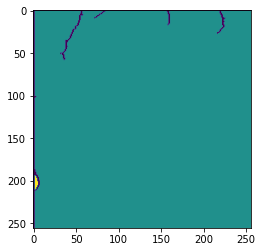

In [10]:
plt.imshow(testseg.squeeze())

In [11]:
np.max(aff)

True

In [22]:
import waterz
from scipy.ndimage import label
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes
import numpy as np


def watershed_from_boundary_distance(
        boundary_distances,
        boundary_mask,
        return_seeds=False,
        id_offset=0,
        min_seed_distance=10):

    max_filtered = maximum_filter(boundary_distances, min_seed_distance)
    maxima = max_filtered==boundary_distances
    seeds, n = label(maxima)
    plt.imshow(seeds)
    print(f"Found {n} fragments")

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds!=0] += id_offset

    fragments = watershed(
        boundary_distances.max() - boundary_distances,
        seeds)

    ret = (fragments.astype(np.uint64), n + id_offset)
    if return_seeds:
        ret = ret + (seeds.astype(np.uint64),)

    return ret


def watershed_from_affinities(
        affs,
        max_affinity_value=1.0,
        fragments_in_xy=True,
        return_seeds=False,
        min_seed_distance=10,
        labels_mask=None):

    mean_affs = (affs[1] + affs[2])>0.5
    depth = mean_affs.shape[0]

    fragments = np.zeros(mean_affs.shape, dtype=np.uint64)
    if return_seeds:
        seeds = np.zeros(mean_affs.shape, dtype=np.uint64)

    id_offset = 0

    for z in range(depth):

        boundary_mask = mean_affs[z]>0.5*max_affinity_value
        boundary_distances = distance_transform_edt(boundary_mask)
        plt.imshow(boundary_distances.squeeze())
        if labels_mask is not None:

            boundary_mask *= labels_mask.astype(bool)

        ret = watershed_from_boundary_distance(
            boundary_distances,
            boundary_mask,
            return_seeds=return_seeds,
            id_offset=id_offset,
            min_seed_distance=min_seed_distance)

        fragments[z] = ret[0]
        if return_seeds:
            seeds[z] = ret[2]

        id_offset = ret[1]

    ret = (fragments)
    if return_seeds:
        ret += (seeds,)

    return ret



# utility function to agglomerate fragments using underlying affinities as edge weights
# returns a segmentation from a final threshold

def get_segmentation(affinities, threshold=.5, labels_mask=None):
    threshold=threshold
    
    fragments = watershed_from_affinities(
            affinities,
            labels_mask=labels_mask)[0]

    thresholds = [threshold]

    generator = waterz.agglomerate(
        affs=affinities.astype(np.float32),
        fragments=fragments,
        thresholds=thresholds,
    )

    segmentation = next(generator)

    
    # remove small holes and relabel connected components
    final_seg, _ = label(
            remove_small_holes(
            segmentation.astype(bool),
            area_threshold=256))

    final_seg = final_seg.astype(np.uint64)

    return final_seg



Found 45 fragments
Re-using already compiled waterz version
Preparing segmentation volume...


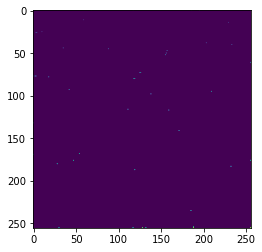

In [23]:
testseg = get_segmentation(affs.astype(np.float), .3)
testseg = testseg.astype(np.uint64)

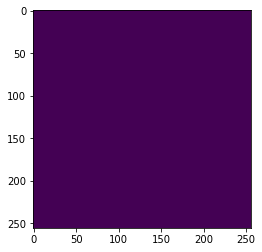

In [24]:
plt.imshow(testseg[0].squeeze())

Found 45 fragments


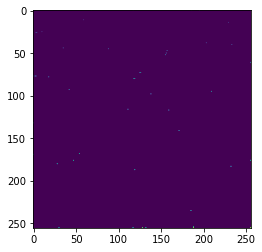

In [25]:
af=watershed_from_affinities(affs)

In [26]:
af

(array([[[10,  1,  1, ...,  6,  6,  6],
         [10, 10,  1, ...,  6,  6,  6],
         [10, 10, 10, ...,  6,  6,  6],
         ...,
         [41, 41, 41, ..., 45, 45, 45],
         [41, 41, 41, ..., 45, 45, 45],
         [41, 41, 41, ..., 45, 45, 45]]], dtype=uint64),
 45)

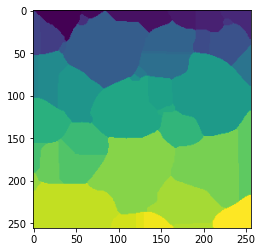

In [29]:
plt.imshow(af[0].squeeze())